<h1 style="font-size:3rem; color:orange">Cuaderno de Martín </h1>

<p>Este es un cuaderno de pruebas. El dataset es la lista de pasajeros del Titanic, con información como la edad o si sobrevivieron al accidente. Procede de 
<a href="https://www.openml.org/search?type=data&sort=nr_of_downloads&status=active&id=40945">aquí</a> y se ha convertido a CSV</p>

In [1]:
import pandas as pd, matplotlib, numpy as np
from scipy.io import arff
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from matplotlib import style
import statsmodels.api as sm
import seaborn as sns
import re

In [110]:
def clean_column_name(name):
    return re.sub(r"^'+|'+$", '', name).strip()
df = pd.read_csv('data/titanic.csv')
df.columns = [clean_column_name(col) for col in df.columns]

In [111]:
mean_values = df['survived'].mean()*100

print(f"{mean_values:.2f}%")

38.20%


Sobrevivió un 38,20% de los pasajeros. Vamos a ver la distribición por sexos.

In [98]:
survival_rate_by_gender = df.groupby('sex')['survived'].mean()
print(survival_rate_by_gender)


sex
0    0.727468
1    0.190985
Name: survived, dtype: float64


Un 72,75% de las mujeres sobrevivieron frente a un 19,10% de los hombres.

In [101]:
class_counts = df['pclass'].value_counts()
print("Número de pasajeros por clase:")
print(class_counts)
survival_rate_by_class = df.groupby('pclass')['survived'].mean() * 100
print("\nPorcentaje de supervivencia de los pasajeros por clase del billete:")
for pclass, rate in survival_rate_by_class.items():
    print(f"Clase {pclass}: {rate:.2f}%")

Número de pasajeros por clase:
pclass
3    709
1    323
2    277
Name: count, dtype: int64

Porcentaje de supervivencia de los pasajeros por clase del billete:
Clase 1: 61.92%
Clase 2: 42.96%
Clase 3: 25.53%


Vamos a hacer ahora un PCA (análisis de componentes principales) para determinar qué variables explican más las posibilidades de supervivencia.

In [69]:
data = df[['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare', 'sex', 'embarked']]

# Eliminar filas con valores nulos
data = data.dropna()

# Codificar variables categóricas
data = pd.get_dummies(data, drop_first=True)

# Separar características y objetivo
X = data.drop('survived', axis=1)
y = data['survived']

#Aquí se estandarizan las medias para que sean 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)  # Puedes cambiar el número de componentes según sea necesario
X_pca = pca.fit_transform(X_scaled)

# Ver las componentes principales
#print("Explained variance ratio:", pca.explained_variance_ratio_)
#print("Principal components:\n", pca.components_)
feature_names = X.columns
print(feature_names)

pca_df = pd.DataFrame(pca.components_, columns=feature_names)

# Mostrar los nombres de las variables junto con sus pesos en los componentes principales
for i, component in enumerate(pca.components_):
    print(f"Principal Component {i+1}:")
    for feature, weight in zip(feature_names, component):
        print(f"{feature}: {weight:.4f}")


Index(['pclass', 'sibsp', 'parch', 'age_0.3333', 'age_0.4167', 'age_0.6667',
       'age_0.75', 'age_0.8333', 'age_0.9167', 'age_1',
       ...
       'fare_9.8417', 'fare_9.8458', 'fare_90', 'fare_91.0792', 'fare_93.5',
       'fare_?', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object', length=386)
Principal Component 1:
pclass: 0.1513
sibsp: 0.1397
parch: 0.1297
age_0.3333: 0.0230
age_0.4167: -0.0273
age_0.6667: 0.0147
age_0.75: -0.0171
age_0.8333: 0.0325
age_0.9167: 0.0223
age_1: 0.0278
age_10: 0.0343
age_11: 0.0273
age_11.5: 0.0172
age_12: -0.0034
age_13: -0.0018
age_14: 0.0183
age_14.5: 0.0047
age_15: -0.0429
age_16: 0.0305
age_17: -0.0038
age_18: 0.0275
age_18.5: -0.0280
age_19: 0.0378
age_2: 0.0645
age_20: 0.0221
age_20.5: 0.0139
age_21: 0.0437
age_22: 0.0158
age_22.5: -0.0326
age_23: 0.0171
age_23.5: -0.0325
age_24: 0.0135
age_24.5: 0.0140
age_25: 0.0187
age_26: 0.0380
age_26.5: -0.0328
age_27: -0.0079
age_28: 0.0560
age_28.5: -0.0336
age_29: 0.0374
ag

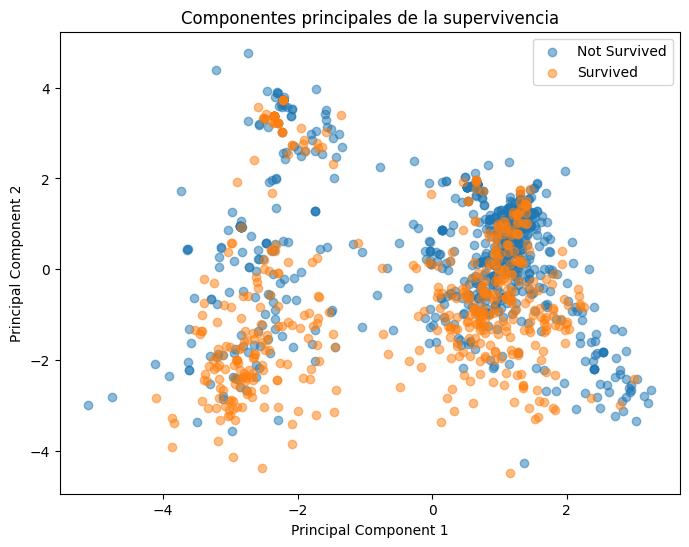

In [66]:
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, df[['survived']]], axis=1)

# Graficar las dos primeras componentes principales
plt.figure(figsize=(8,6))
plt.scatter(pca_df[pca_df['survived'] == 0]['PC1'], pca_df[pca_df['survived'] == 0]['PC2'], label='Not Survived', alpha=0.5)
plt.scatter(pca_df[pca_df['survived'] == 1]['PC1'], pca_df[pca_df['survived'] == 1]['PC2'], label='Survived', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('Componentes principales de la supervivencia en el Titanic')
plt.show()

Examinémoslo ahora con uno de los estadísticos más conocidos, la correlación de Pearson.

In [112]:
df['sex'] = df['sex'].map({'male': 1, 'female': 0})

print(df['sex'].unique())
correlation = df['sex'].corr(df['survived'])
print(f"Correlación entre sexo y supervivencia: {correlation:.4f}")


[0 1]
Correlación entre sexo y supervivencia: -0.5287


Dado que hemos asignado 1 a Hombre, la correlación significa que hay una relación negativa y moderada entre ser hombre y sobrevivir. Para estimar mejor la relación, podemos usar la estimación chi cuadrado.

In [113]:
from scipy import stats


contingency_table = pd.crosstab(df['sex'], df['survived'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Prueba chi cuadrado: {chi2:.4f}")
print(f"P-value: {p:.4f}")

Chi-square test statistic: 363.6179
P-value: 0.0000


Al ser P < que el intervalo de confianza (0,05) rechazamos la hipótesis nula de que no hay relación entre sexo y tasa de supervencia, aceptando la nula.

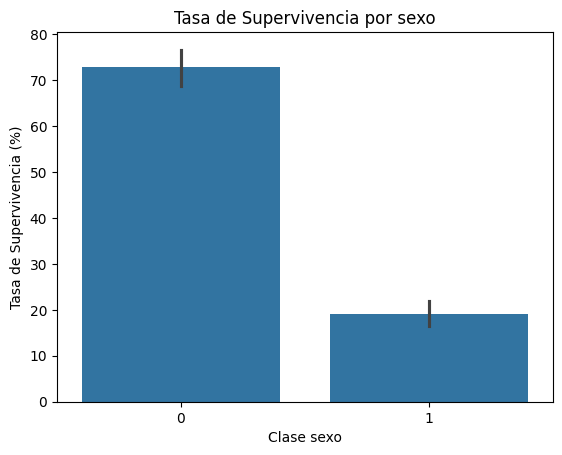

In [116]:
sns.barplot(x='sex', y='survived', data=df, estimator=lambda x: sum(x) / len(x) * 100)
plt.xlabel('Sexo')
plt.ylabel('Tasa de Supervivencia (%)')
plt.title('Tasa de Supervivencia por sexo')
plt.show()

In [105]:
correlation_class = df['pclass'].corr(df['survived'])
print(f"Correlación entre clase del billete y supervivencia: {correlation_class:.4f}")

Correlación entre clase del billete y supervivencia: -0.3125


Es un correlación moderada que significa que a medida que aumenta el número del billete (es decir, eres de clase más baja) disminiuyen las probabilidades de sobrevivir. 

In [115]:
contingency_table = pd.crosstab(df['pclass'], df['survived'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Prueba chi cuadrado: {chi2:.4f}")
print(f"P-value: {p:.4f}")

Prueba chi cuadrado: 127.8592
P-value: 0.0000


Ejecutamos la prueba chi cuadrado y otra vez vemos que p<0,05

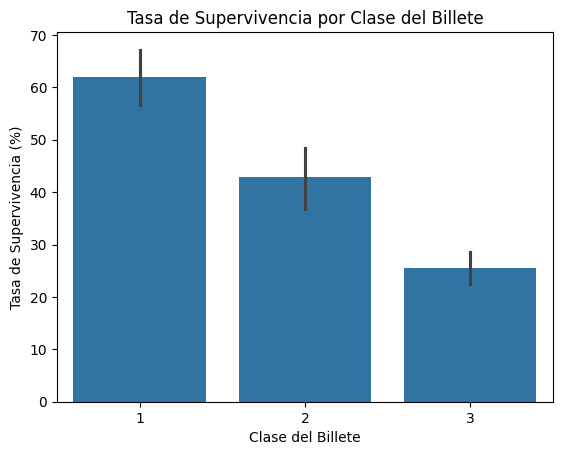

In [103]:
sns.barplot(x='pclass', y='survived', data=df, estimator=lambda x: sum(x) / len(x) * 100)
plt.xlabel('Clase del Billete')
plt.ylabel('Tasa de Supervivencia (%)')
plt.title('Tasa de Supervivencia por Clase del Billete')
plt.show()
